In [137]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import statsmodels.api as sm

In [138]:
data = pd.read_csv('final_file.csv', parse_dates=['order_date','ship_date'], date_parser=lambda x: pd.to_datetime(x, format='mixed', dayfirst=True))

# Check the data
import warnings
warnings.filterwarnings("ignore")

In [139]:
data.head()

,city,customer_age,customer_name,customer_segment,discount,order_date,order_id,order_priority,order_quantity,product_base_margin,...,product_sub_category,profit,region,sales,ship_date,ship_mode,shipping_cost,state,unit_price,zip_code
0,Stevens Point,60,Dennis Bolton,Corporate,0.17,2020-02-29,a42c8cff-5757-4e94-80b0-807538fefd25,Not Specified,7,0.55,...,Chairs & Chairmats,19559.92268,Central,21.84,2020-03-02,Delivery Truck,3.772509,Wisconsin,3.29,54481.0
1,Stevens Point,60,Dennis Bolton,Corporate,0.17,2020-02-29,1c37f301-564f-40ff-bd7d-73a6c06ede1a,Not Specified,7,0.55,...,Chairs & Chairmats,19559.92268,Central,1811.67,2020-03-07,Delivery Truck,816.340893,Wisconsin,258.98,54481.0
2,Grapevine,49,Anthony Garverick,Small Business,0.05,2021-11-11,ec649eae-535d-4154-b3ef-c4405bd59da9,Medium,42,0.69,...,Tables,7535.93880,Central,6129.06,2021-11-15,Delivery Truck,4530.505983,Texas,145.98,76051.0
3,Tempe,30,Anne McFarland,Consumer,0.05,2020-08-02,efdcbace-5320-4005-95e2-4c94a896dc8c,Not Specified,30,0.37,...,Paper,18860.92419,West,198.90,2020-08-08,Regular Air,128.731505,Arizona,6.68,85281.0
4,Upper Arlington,84,Sara Luxemburg,Corporate,0.25,2020-09-26,6b88eca0-426a-4fd4-83c6-1657c43f94a0,High,31,0.77,...,Computer Peripherals,20175.51620,East,243.97,2020-09-30,Express Air,17.811073,Ohio,8.12,43221.0


In [140]:
data.tail()

,city,customer_age,customer_name,customer_segment,discount,order_date,order_id,order_priority,order_quantity,product_base_margin,...,product_sub_category,profit,region,sales,ship_date,ship_mode,shipping_cost,state,unit_price,zip_code
1009313,Tiverton,55,Roland Murray,Corporate,0.15,2019-07-13,53d46dc3-d6cb-4a55-8626-1614aa9f3d77,Medium,50,0.58,...,Storage & Organization,15732.04569,East,1406.50,2019-07-21,Express Air,1092.369372,Rhode Island,28.28,2878.0
1009314,Vestavia Hills,63,Ed Jacobs,Corporate,0.18,2020-04-23,243e3616-443d-4f35-8534-8a680f364188,Low,31,0.59,...,Storage & Organization,20701.07035,South,241.80,2020-04-28,Express Air,44.258342,Alabama,7.98,35216.0
1009315,Fort Worth,79,Eugene Moren,Small Business,0.25,2020-06-18,c2cff208-474b-47d8-a956-c0703d5a11ba,Medium,2,0.37,...,Binders and Binder Accessories,-2951.55084,Central,3.82,2020-06-27,Express Air,0.106669,Texas,2.16,76106.0
1009316,Huntington Beach,62,Randy Ferguson,Small Business,0.09,2020-06-07,3b3e237d-bf45-4b07-aecd-8e4e47ca47ec,Critical,24,0.81,...,Storage & Organization,22180.49814,West,1941.36,2020-06-17,Express Air,324.770871,California,80.98,92646.0
1009317,Saratoga,62,Liz Willingham,Small Business,0.05,2020-12-01,b317e74c-9891-4c0d-9977-aaf767b2721e,Critical,11,0.82,...,Storage & Organization,9140.72233,West,1114.96,2020-12-09,Regular Air,125.152699,California,101.41,95070.0


In [141]:
# Check the data types
data.dtypes

city                            object
customer_age                     int64
customer_name                   object
customer_segment                object
discount                       float64
order_date              datetime64[ns]
order_id                        object
order_priority                  object
order_quantity                   int64
product_base_margin            float64
product_category                object
product_container               object
product_name                    object
product_sub_category            object
profit                         float64
region                          object
sales                          float64
ship_date               datetime64[ns]
ship_mode                       object
shipping_cost                  float64
state                           object
unit_price                     float64
zip_code                       float64
dtype: object

### Outlier Handling

In [142]:
data2=data.copy()
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data2['sales'].quantile(0.25)
Q3 = data2['sales'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define outliers based on 1.5*IQR rule
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df10 = data2['sales'].apply(lambda x: (x if x < lower_bound else None ) or (x if x > upper_bound else None))
print(df10.count())
# Replace outliers with boundary values
data2['sales'] = data2['sales'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# Print DataFrame after replacing outliers
#print("DataFrame after replacing outliers:")
print(data2)

124888
                     city  customer_age      customer_name customer_segment  \
0           Stevens Point            60      Dennis Bolton        Corporate   
1           Stevens Point            60      Dennis Bolton        Corporate   
2               Grapevine            49  Anthony Garverick   Small Business   
3                   Tempe            30     Anne McFarland         Consumer   
4         Upper Arlington            84     Sara Luxemburg        Corporate   
...                   ...           ...                ...              ...   
1009313          Tiverton            55      Roland Murray        Corporate   
1009314    Vestavia Hills            63          Ed Jacobs        Corporate   
1009315        Fort Worth            79       Eugene Moren   Small Business   
1009316  Huntington Beach            62     Randy Ferguson   Small Business   
1009317          Saratoga            62     Liz Willingham   Small Business   

         discount order_date                

In [143]:
data2.shape

(1009318, 23)

### Sample set for trial

In [144]:
sample = data2.sample(n=50000, random_state=42)

In [145]:
sample.shape

(50000, 23)

In [146]:
sample.tail()

,city,customer_age,customer_name,customer_segment,discount,order_date,order_id,order_priority,order_quantity,product_base_margin,...,product_sub_category,profit,region,sales,ship_date,ship_mode,shipping_cost,state,unit_price,zip_code
395483,Casselberry,43,Daniel Lacy,Home Office,0.14,2019-04-12,8e7b8f4a-9c3e-4796-aead-aa8f26addc78,Critical,47,0.50,...,Computer Peripherals,2154.59281,South,4408.89,2019-04-17,Express Air,2032.611597,Florida,99.99,32707.0
970586,Mason,49,Julie Prescott,Home Office,0.04,2021-11-13,2f7422d8-5edc-4a70-9cf2-6c238c75921e,High,24,0.37,...,Paper,4321.86202,East,154.56,2021-11-18,Regular Air,37.289310,Ohio,6.48,45040.0
56425,Kingsville,40,Bart Watters,Corporate,0.21,2020-03-12,5155b8eb-7394-40aa-918b-357dfa6bdff0,Medium,3,0.44,...,Pens & Art Supplies,26202.19497,Central,6.93,2020-03-15,Regular Air,5.099401,Texas,2.52,78363.0
18829,Roanoke,46,Larry Blacks,Corporate,0.01,2022-11-23,9ec1ca49-d471-48d6-8047-a25113224e59,Critical,32,0.35,...,Telephones and Communication,4072.26220,South,1151.36,2022-11-25,Delivery Truck,269.085711,Virginia,35.99,24017.0
6998,Bremerton,55,Damala Kotsonis,Corporate,0.19,2021-07-20,d49d9242-785c-4b30-a232-28a76161f332,Medium,41,0.57,...,Chairs & Chairmats,12137.43480,West,3926.16,2021-07-23,Express Air,2478.832163,Washington,95.95,98310.0


In [147]:
# Aggregate sales by date to remove duplicates
df = sample.groupby('order_date').agg({'sales': 'sum'}).reset_index()
#set index as date
df.set_index('order_date', inplace=True)

In [148]:
df.shape

(1461, 1)

In [149]:
df.head()

,sales
order_date,
2019-01-01,37659.47
2019-01-02,60052.86
2019-01-03,44292.47
2019-01-04,38410.81
2019-01-05,49022.58


In [150]:
df.tail()

,sales
order_date,
2022-12-27,47285.99
2022-12-28,51830.10
2022-12-29,34267.36
2022-12-30,30130.00
2022-12-31,26365.62


In [151]:
# Resample the data by month and calculate the sum of sales
df_monthly = df.resample('M').agg({'sales': 'sum'}).reset_index()

# If you need to add the monthly sum back to the original DataFrame
df['month_s'] = df['sales'].resample('M').transform('sum')

# Reset the index if necessary
df.reset_index(inplace=True)

In [152]:
df.head()

,order_date,sales,month_s
0,2019-01-01,37659.47,1343560.4
1,2019-01-02,60052.86,1343560.4
2,2019-01-03,44292.47,1343560.4
3,2019-01-04,38410.81,1343560.4
4,2019-01-05,49022.58,1343560.4


In [153]:
df['month'] = df['order_date'].dt.to_period('M')

In [154]:
df.shape

(1461, 4)

In [155]:
df.set_index('month',inplace=True)

In [156]:
df.columns

Index(['order_date', 'sales', 'month_s'], dtype='object')

In [157]:
df.head()

,order_date,sales,month_s
month,,,
2019-01,2019-01-01,37659.47,1343560.4
2019-01,2019-01-02,60052.86,1343560.4
2019-01,2019-01-03,44292.47,1343560.4
2019-01,2019-01-04,38410.81,1343560.4
2019-01,2019-01-05,49022.58,1343560.4


In [158]:
df.describe()

,order_date,sales,month_s
count,1461,1461.000000,1.461000e+03
mean,2020-12-31 00:00:00,42367.232272,1.290293e+06
min,2019-01-01 00:00:00,10094.370000,1.191165e+06
25%,2020-01-01 00:00:00,34597.650000,1.245993e+06
50%,2020-12-31 00:00:00,41852.380000,1.277333e+06
75%,2021-12-31 00:00:00,49834.300000,1.343560e+06
max,2022-12-31 00:00:00,96667.820000,1.398021e+06
std,NaN,11602.351736,5.775347e+04


In [159]:
df.columns

Index(['order_date', 'sales', 'month_s'], dtype='object')

In [160]:
'''df=data.drop(['city', 'customer_age', 'customer_name', 'customer_segment', 'discount',
       'order_id', 'order_priority', 'order_quantity', 'product_base_margin',
       'product_category', 'product_container', 'product_name',
       'product_sub_category', 'profit', 'region', 'ship_date',
       'ship_mode', 'shipping_cost', 'state', 'unit_price', 'zip_code','order_date'],axis=1)'''

"df=data.drop(['city', 'customer_age', 'customer_name', 'customer_segment', 'discount',\n       'order_id', 'order_priority', 'order_quantity', 'product_base_margin',\n       'product_category', 'product_container', 'product_name',\n       'product_sub_category', 'profit', 'region', 'ship_date',\n       'ship_mode', 'shipping_cost', 'state', 'unit_price', 'zip_code','order_date'],axis=1)"

In [161]:
df.dtypes

order_date    datetime64[ns]
sales                float64
month_s              float64
dtype: object

In [162]:
data3=df.drop(['order_date','sales'],axis=1)

In [163]:
data3.head()

,month_s
month,
2019-01,1343560.4
2019-01,1343560.4
2019-01,1343560.4
2019-01,1343560.4
2019-01,1343560.4


<Axes: xlabel='month'>

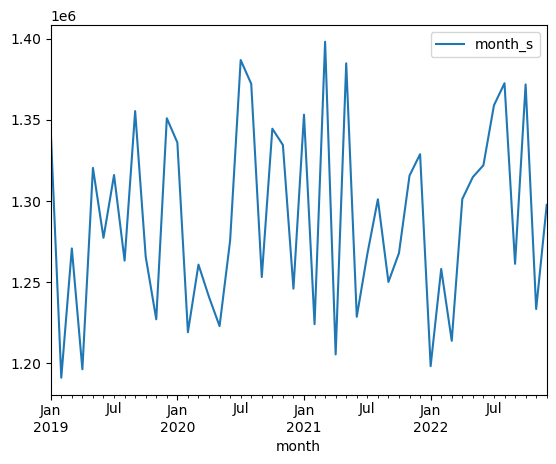

In [164]:
data3.plot()

### Testing For Stationarity
#### Augmented Dickey–Fuller test
#Ho: It is non stationary
#H1: It is stationary

In [165]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(data3['month_s'])

In [166]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        

In [167]:
adfuller_test(data3['month_s'])

ADF Test Statistic : -5.508988812660367
p-value : 1.9918552068475177e-06
#Lags Used : 0
Number of Observations Used : 1460
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [168]:
# from above steps we can say that time series is stationary

### Autoregressive model

In [169]:
from pandas.plotting import autocorrelation_plot

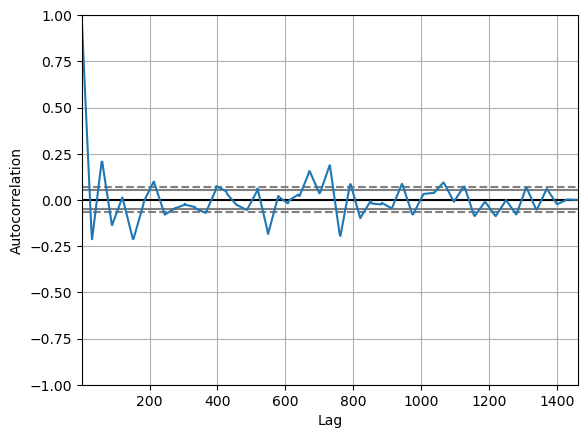

In [170]:
autocorrelation_plot(data3['month_s'])
plt.show()

In [171]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [172]:
import statsmodels.api as sm

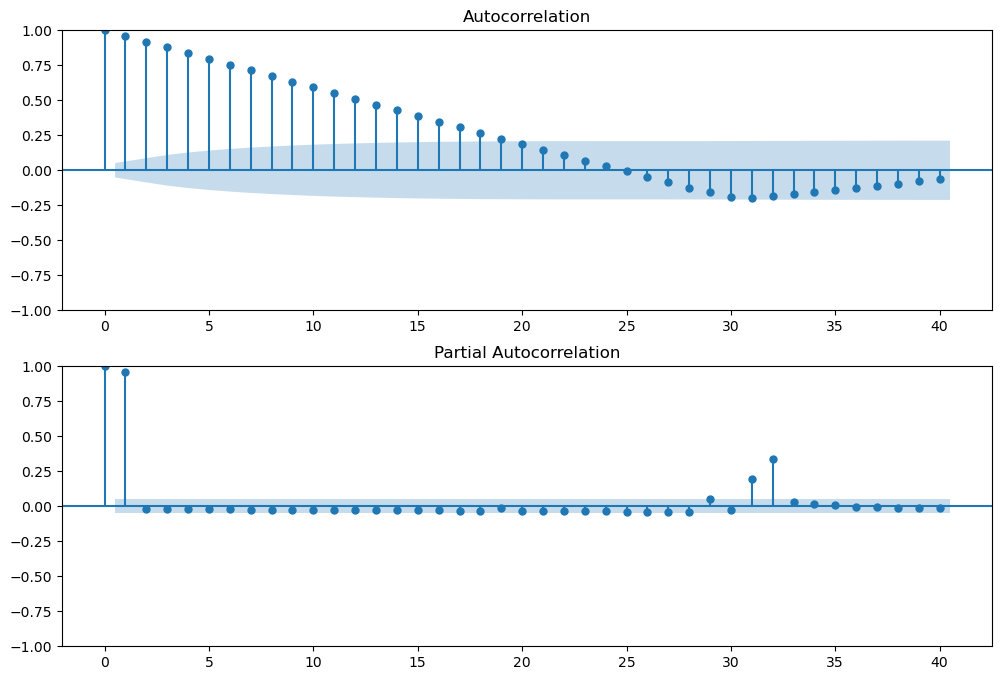

In [173]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data3['month_s'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data3['month_s'].iloc[13:],lags=40,ax=ax2)

In [174]:
#For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

In [175]:
data3.head()

,month_s
month,
2019-01,1343560.4
2019-01,1343560.4
2019-01,1343560.4
2019-01,1343560.4
2019-01,1343560.4


In [176]:
model=ARIMA(data3['month_s'],order=(1,1,1))
model_fit=model.fit()

In [177]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                month_s   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -16239.001
Date:                Wed, 14 Aug 2024   AIC                          32484.002
Time:                        17:12:38   BIC                          32499.860
Sample:                    01-31-2019   HQIC                         32489.918
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       6.256e-09      0.003   1.88e-06      1.000      -0.007       0.007
ma.L1      -6.256e-09      0.003  -1.88e-06      1.000      -0.007       0.007
sigma2       2.69e+08   1.71e+06    157.703      0.000    2.66e+08    2.72e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            269276.14
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.93
Prob(H) (two-sided):                  0.01   Kurtosis:                        69.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.29e+34. Standard errors may be unstable.
"""

In [178]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1461 entries, 2019-01 to 2022-12
Freq: M
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   month_s  1461 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


### Check Duplicates 

In [199]:
#There are duplicate value in index so we need to chaeck that
duplicates = data3.index.duplicated()
if duplicates.any():
    print("Duplicate indices found:\n", data3[duplicates])
else:
    print("No duplicate indices found.")

Duplicate indices found:
             month_s
month              
2019-01  1343560.40
2019-01  1343560.40
2019-01  1343560.40
2019-01  1343560.40
2019-01  1343560.40
...             ...
2022-12  1297600.73
2022-12  1297600.73
2022-12  1297600.73
2022-12  1297600.73
2022-12  1297600.73

[1413 rows x 1 columns]


In [200]:
# we have to remove duplicates from each index
df10 = data3[~data3.index.duplicated(keep='first')]
df11 = data3[~data3.index.duplicated(keep='first')]

In [201]:
df10.head()

,month_s
month,
2019-01,1343560.40
2019-02,1191165.38
2019-03,1270771.45
2019-04,1196374.88
2019-05,1320339.45


<Axes: xlabel='month'>

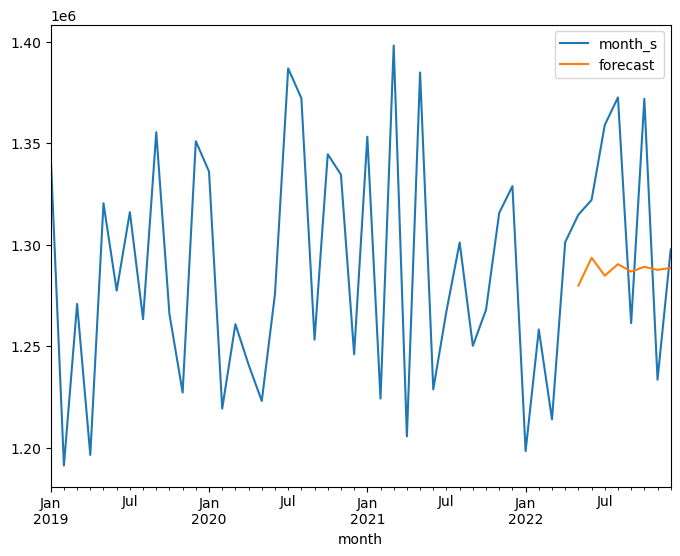

In [202]:
# Fit ARIMA model (example with order (1, 1, 1))
model = ARIMA(df10['month_s'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast
df10['forecast'] = model_fit.predict(start=40, end=48, dynamic=True)

# Plot
df10[['month_s', 'forecast']].plot(figsize=(8, 6))
#plt.show()

In [203]:
model=sm.tsa.statespace.SARIMAX(df10['month_s'],order=(32, 0, 11))
results=model.fit()

<Axes: xlabel='month'>

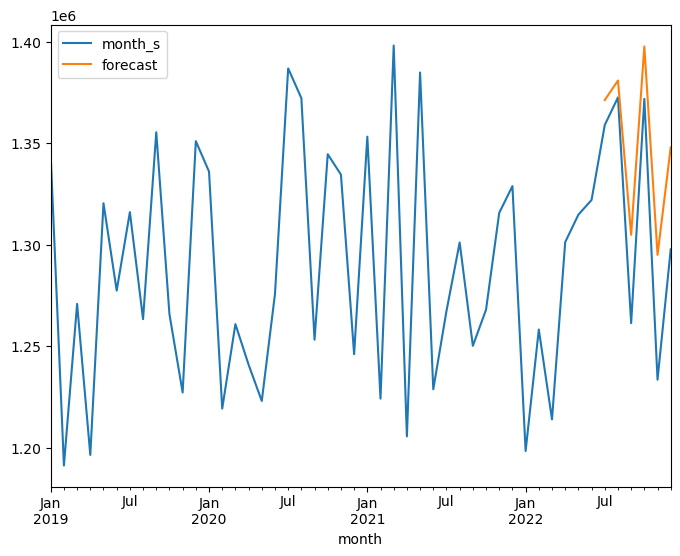

In [204]:
df10['forecast']=results.predict(start=42,end=48,dynamic=True)
df10[['month_s','forecast']].plot(figsize=(8,6))

### Splitting Data & Forcasting on Test data
#Train 90% & Test 10%

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assume df is your DataFrame with a 'Sales' column
# Splitting the data into training and testing sets
train_size = int(len(df10) * 0.9)  # 90% training, 10% testing
train, test = df10['month_s'][:train_size], df10['month_s'][train_size:]

In [206]:
start = len(train)
end = len(train) + len(test) - 1
forecast = model_fit.predict(start=start, end=end, dynamic=False)

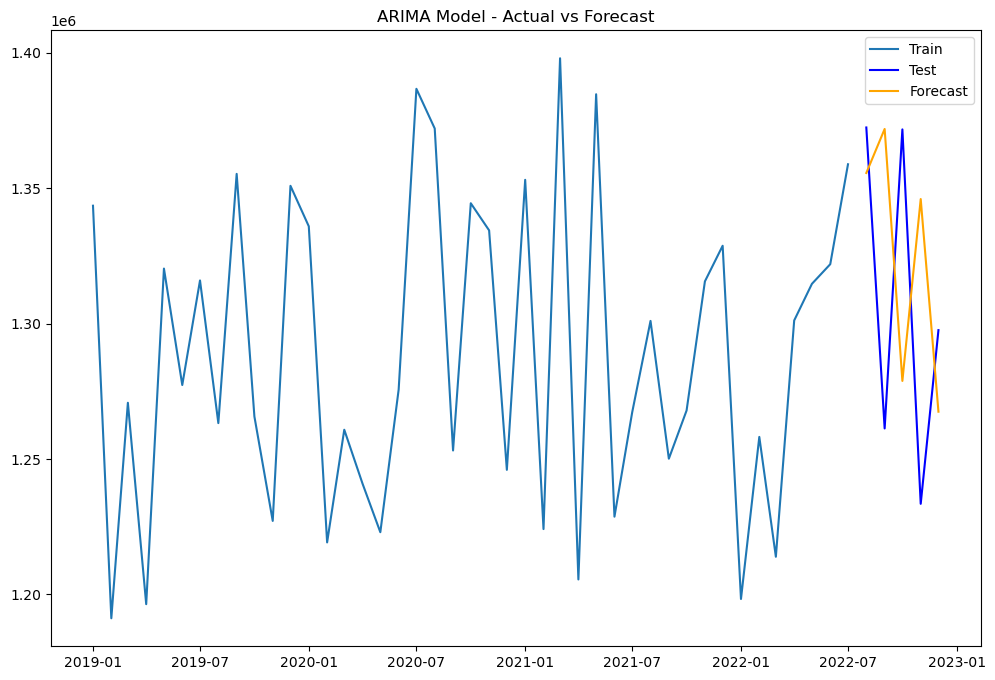

In [207]:
# Assuming train, test, and forecast are your data series

# Convert PeriodIndex to DatetimeIndex if necessary
if isinstance(train.index, pd.PeriodIndex):
    train.index = train.index.to_timestamp()

if isinstance(test.index, pd.PeriodIndex):
    test.index = test.index.to_timestamp()

if isinstance(forecast.index, pd.PeriodIndex):
    forecast.index = forecast.index.to_timestamp()

# Plotting the actual vs predicted values
plt.figure(figsize=(12, 8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('ARIMA Model - Actual vs Forecast')
plt.legend(loc='best')
plt.show()


In [208]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(test, forecast)
print(f'R-squared: {r2}')

Mean Absolute Error (MAE): 72609.26479651142
Mean Squared Error (MSE): 6946816905.203486
Root Mean Squared Error (RMSE): 83347.56688232408
R-squared: -1.162144551128681


### For Entire Dataset

In [210]:
data2.shape

(1009318, 23)

In [211]:
# Aggregate sales by date to remove duplicates
df2 = data2.groupby('order_date').agg({'sales': 'sum'}).reset_index()
#set index as date
df2.set_index('order_date', inplace=True)

In [212]:
# Resample the data by month and calculate the sum of sales
df_monthly = df2.resample('M').agg({'sales': 'sum'}).reset_index()

# If you need to add the monthly sum back to the original DataFrame
df2['month_sum'] = df2['sales'].resample('M').transform('sum')

df2.reset_index(inplace=True)


In [213]:
df2.tail(10)

,order_date,sales,month_sum
1451,2022-12-22,853321.58,26725583.37
1452,2022-12-23,915536.53,26725583.37
1453,2022-12-24,824416.43,26725583.37
1454,2022-12-25,908115.05,26725583.37
1455,2022-12-26,882160.30,26725583.37
1456,2022-12-27,885005.04,26725583.37
1457,2022-12-28,860106.45,26725583.37
1458,2022-12-29,869793.52,26725583.37
1459,2022-12-30,914668.22,26725583.37
1460,2022-12-31,843658.57,26725583.37


In [214]:
df2['month'] = df2['order_date'].dt.to_period('M')

In [215]:
df2.head()

,order_date,sales,month_sum,month
0,2019-01-01,793877.16,26462081.13,2019-01
1,2019-01-02,909337.74,26462081.13,2019-01
2,2019-01-03,878111.88,26462081.13,2019-01
3,2019-01-04,796853.02,26462081.13,2019-01
4,2019-01-05,937855.53,26462081.13,2019-01


In [216]:
df2.set_index('month',inplace=True)

In [217]:
df2.columns

Index(['order_date', 'sales', 'month_sum'], dtype='object')

In [218]:
df2.tail(10)

,order_date,sales,month_sum
month,,,
2022-12,2022-12-22,853321.58,26725583.37
2022-12,2022-12-23,915536.53,26725583.37
2022-12,2022-12-24,824416.43,26725583.37
2022-12,2022-12-25,908115.05,26725583.37
2022-12,2022-12-26,882160.30,26725583.37
2022-12,2022-12-27,885005.04,26725583.37
2022-12,2022-12-28,860106.45,26725583.37
2022-12,2022-12-29,869793.52,26725583.37
2022-12,2022-12-30,914668.22,26725583.37


In [219]:
df3=df2.drop(['order_date', 'sales'],axis=1)

In [220]:
df3.tail()

,month_sum
month,
2022-12,26725583.37
2022-12,26725583.37
2022-12,26725583.37
2022-12,26725583.37
2022-12,26725583.37


<Axes: xlabel='month'>

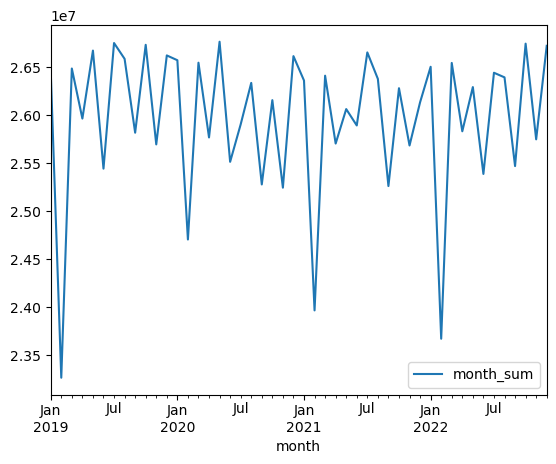

In [221]:
df3.plot()

### Cheack Stationarity

In [222]:
test_result=adfuller(df3['month_sum'])

In [223]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(month_sum):
    result=adfuller(month_sum)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [224]:
adfuller_test(df3['month_sum'])

ADF Test Statistic : -9.303232876809172
p-value : 1.0980979904404834e-15
#Lags Used : 24
Number of Observations Used : 1436
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## Autoregressive model

In [225]:
from pandas.plotting import autocorrelation_plot

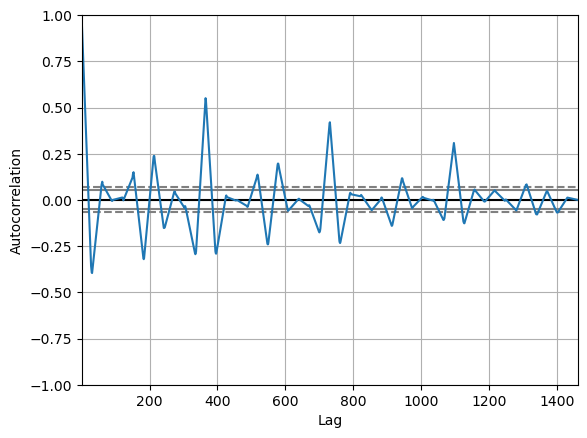

In [226]:
autocorrelation_plot(df3['month_sum'])
plt.show()

In [227]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [228]:
import statsmodels.api as sm

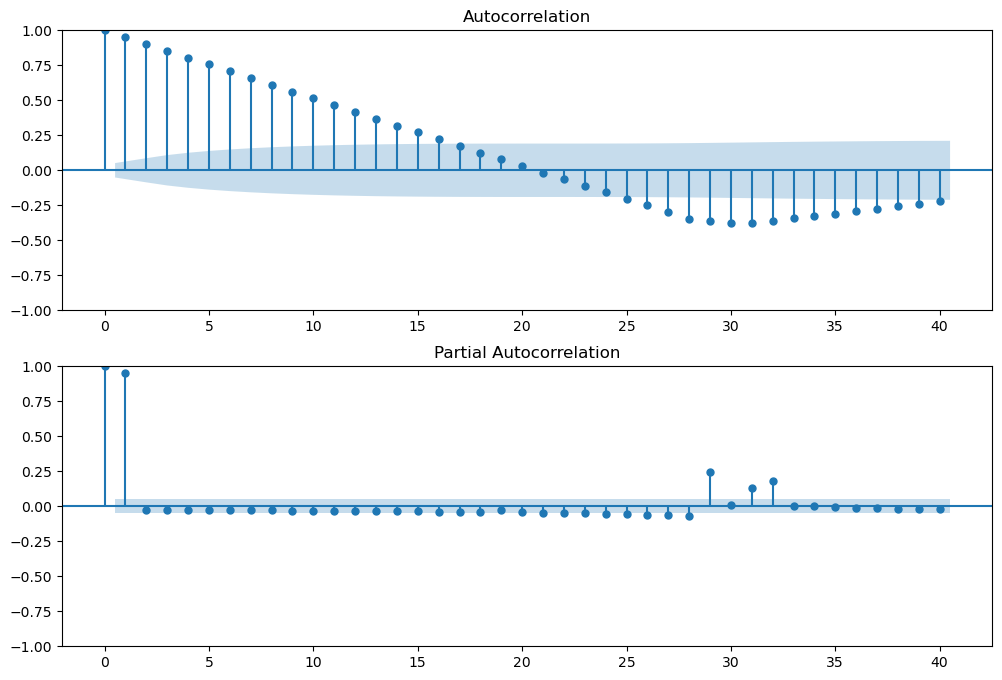

In [229]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df3['month_sum'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df3['month_sum'].iloc[13:],lags=40,ax=ax2)

In [230]:
#For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

In [231]:
df3.head()

,month_sum
month,
2019-01,26462081.13
2019-01,26462081.13
2019-01,26462081.13
2019-01,26462081.13
2019-01,26462081.13


In [232]:
model=ARIMA(df3['month_sum'],order=(1,1,1))
model_fit=model.fit()

In [233]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              month_sum   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20145.789
Date:                Wed, 14 Aug 2024   AIC                          40297.578
Time:                        17:23:35   BIC                          40313.436
Sample:                    01-31-2019   HQIC                         40303.494
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       9.371e-09   2.88e+11   3.26e-20      1.000   -5.64e+11    5.64e+11
ma.L1      -9.371e-09   2.88e+11  -3.26e-20      1.000   -5.64e+11    5.64e+11
sigma2      5.675e+10   2.99e+08    189.790      0.000    5.62e+10    5.73e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            575089.89
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                       100.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+16. Standard errors may be unstable.
"""

In [234]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1461 entries, 2019-01 to 2022-12
Freq: M
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   month_sum  1461 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


In [235]:
df3.head()

,month_sum
month,
2019-01,26462081.13
2019-01,26462081.13
2019-01,26462081.13
2019-01,26462081.13
2019-01,26462081.13


In [236]:
#df4=df3.drop(['Sales First Difference','Seasonal First Difference'],axis=1)

In [237]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1461 entries, 2019-01 to 2022-12
Freq: M
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   month_sum  1461 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


In [238]:
#There are duplicate value in index so we need to chaeck that
duplicates = df3.index.duplicated()
if duplicates.any():
    print("Duplicate indices found:\n", df3[duplicates])
else:
    print("No duplicate indices found.")

Duplicate indices found:
            month_sum
month               
2019-01  26462081.13
2019-01  26462081.13
2019-01  26462081.13
2019-01  26462081.13
2019-01  26462081.13
...              ...
2022-12  26725583.37
2022-12  26725583.37
2022-12  26725583.37
2022-12  26725583.37
2022-12  26725583.37

[1413 rows x 1 columns]


In [239]:
# we have to remove duplicates from each index
df5 = df3[~df3.index.duplicated(keep='first')]
df4 = df3[~df3.index.duplicated(keep='first')]

In [240]:
df5.head()

,month_sum
month,
2019-01,26462081.13
2019-02,23262900.25
2019-03,26488513.31
2019-04,25966238.65
2019-05,26675574.93


In [241]:
df4.head()

,month_sum
month,
2019-01,26462081.13
2019-02,23262900.25
2019-03,26488513.31
2019-04,25966238.65
2019-05,26675574.93


In [242]:
#df5.to_csv('monthly_sales.csv',index=True)

<Axes: xlabel='month'>

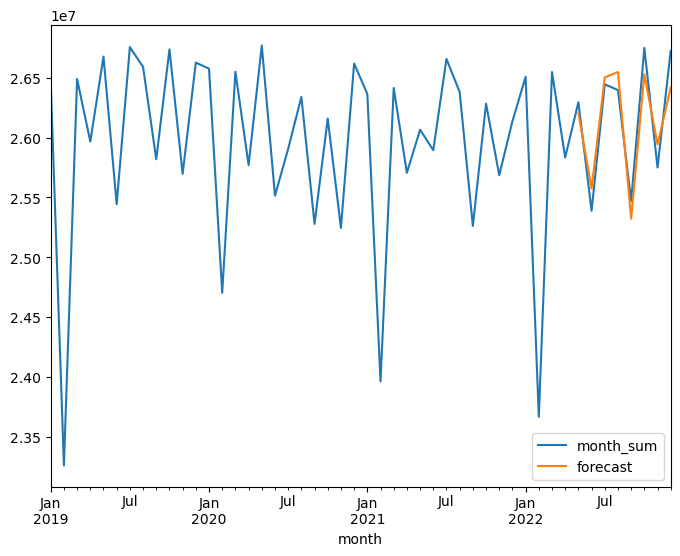

In [243]:
# Fit ARIMA model (example with order (1, 1, 1))
model = ARIMA(df5['month_sum'], order=(13, 0, 28))
model_fit = model.fit()

# Forecast
df5['forecast'] = model_fit.predict(start=40, end=48, dynamic=True)

# Plot
df5[['month_sum', 'forecast']].plot(figsize=(8, 6))
#plt.show()

In [244]:
model=sm.tsa.statespace.SARIMAX(df5['month_sum'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

<Axes: xlabel='month'>

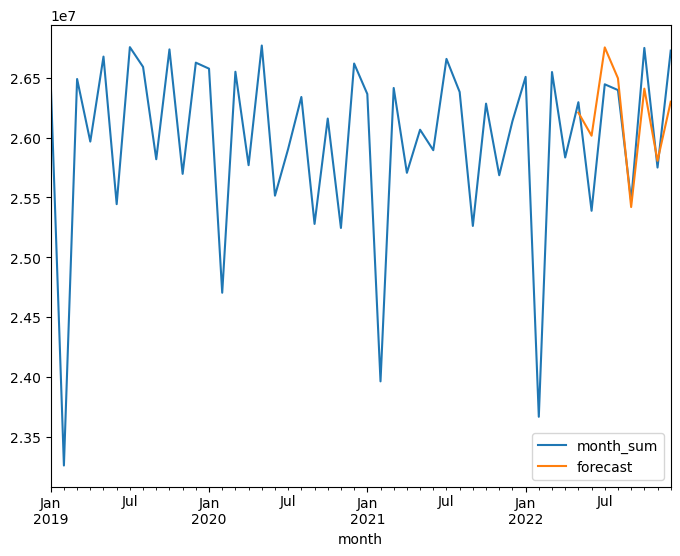

In [245]:
df5['forecast']=results.predict(start=40,end=48,dynamic=True)
df5[['month_sum','forecast']].plot(figsize=(8,6))

In [246]:
df5.head()

,month_sum,forecast
month,,
2019-01,26462081.13,NaN
2019-02,23262900.25,NaN
2019-03,26488513.31,NaN
2019-04,25966238.65,NaN
2019-05,26675574.93,NaN


### try

In [247]:
# Assuming df5 contains your sales data and the last few months are for forecasting
#model = ARIMA(df5['month_sum'], order=(1, 1, 1))
#model_fit = model.fit()

# Forecast for a specific period
#forecast = model_fit.predict(start=len(df5), end=len(df5)+10, dynamic=True)

# Combine the original sales data with the forecast
#df5['forecast'] = forecast

# Plotting the results
#plt.figure(figsize=(12, 8))
#plt.plot(df5.index, df5['month_sum'], label='Sales', color='blue')
#plt.plot(df5.index, df5['forecast'], label='Forecast', color='orange')
#plt.legend(loc='best')
#plt.show()

In [248]:
# Convert PeriodIndex to DatetimeIndex
#df5.index = df5.index.to_timestamp()

# Now you can perform operations like forecasting and plotting
#model = ARIMA(df5['month_sum'], order=(1, 1, 1))
#model_fit = model.fit()

# Forecasting
#forecast = model_fit.predict(start=len(df5), end=len(df5)+10, dynamic=True)

# Combine the original sales data with the forecast
#df5['forecast'] = forecast


### Splitting Data & Forcasting on Test data 
#Train 90% & Test 10%

In [249]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assume df is your DataFrame with a 'Sales' column
# Splitting the data into training and testing sets
train_size = int(len(df5) * 0.9)  # 90% training, 10% testing
train, test = df5['month_sum'][:train_size], df5['month_sum'][train_size:]

In [250]:
start = len(train)
end = len(train) + len(test) - 1
forecast = model_fit.predict(start=start, end=end, dynamic=False)

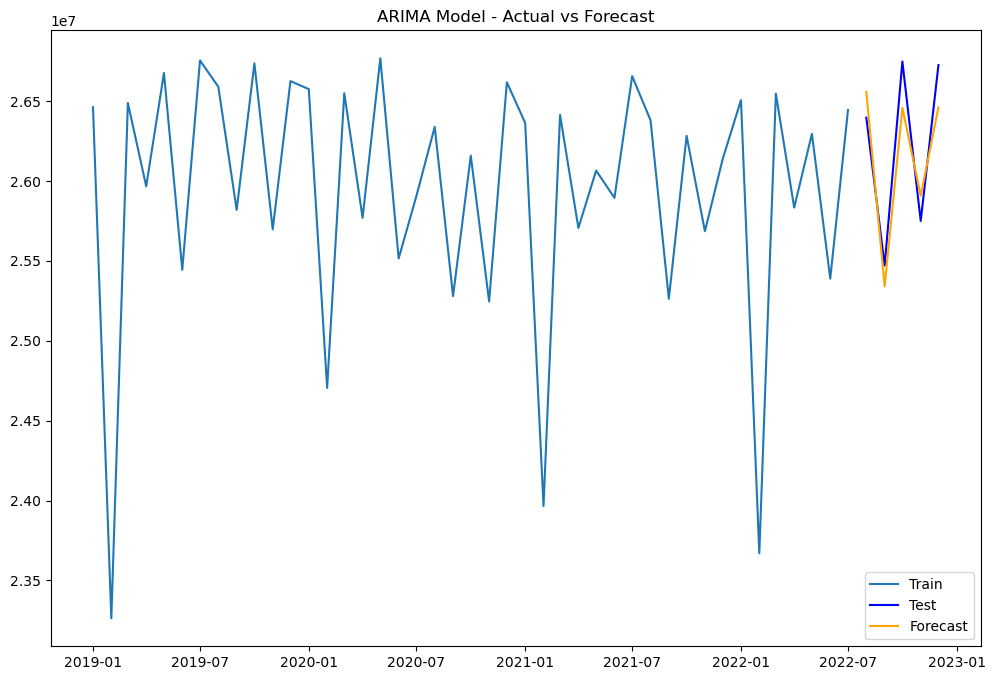

In [251]:
# Convert PeriodIndex to DatetimeIndex
train.index = train.index.to_timestamp()
test.index = test.index.to_timestamp()
forecast.index = forecast.index.to_timestamp()
# Plotting the actual vs predicted values
plt.figure(figsize=(12, 8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('ARIMA Model - Actual vs Forecast')
plt.legend(loc='best')
plt.show()

In [252]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(test, forecast)
print(f'R-squared: {r2}')

Mean Absolute Error (MAE): 200783.2478274867
Mean Squared Error (MSE): 44416415150.651
Root Mean Squared Error (RMSE): 210752.02288626082
R-squared: 0.8352562137335056
